##### EDA Robusta para Melhoria do Modelo de Análise
##### 
##### **Objetivo:** Esta análise vai além da exploração básica para encontrar oportunidades de aprimorar nosso sistema. O foco é:
##### 1.  **Qualidade do Texto:** Garantir que o texto enviado ao LLM seja o mais limpo e relevante possível.
##### 2.  **Engenharia de Features:** Criar novas variáveis que possam revelar padrões de comportamento do usuário e tendências temporais.
##### 3.  **Análise de Sentimento:** Validar a consistência entre a nota (`score`) e o sentimento do texto.
##### 4.  **Insights Acionáveis:** Derivar conclusões que se traduzam em melhorias na pipeline de dados e na aplicação final.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html
import ast
from datetime import datetime
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Danilo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danilo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
ratings_df = pd.read_csv('../data/books_rating.csv', nrows=500000)
metadata_df = pd.read_csv('../data/books_data.csv')

In [3]:
ratings_df.head(3)

,Id,Title,Price,User_id,profileName,score,time,summary,text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."


In [4]:
metadata_df.head(3)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN


In [5]:
ratings_df.info()
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Id           500000 non-null  object 
 1   Title        499993 non-null  object 
 2   Price        80099 non-null   float64
 3   User_id      403654 non-null  object 
 4   profileName  403642 non-null  object 
 5   score        500000 non-null  float64
 6   time         500000 non-null  int64  
 7   summary      499931 non-null  object 
 8   text         499999 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 34.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image        

In [6]:
ratings_df.duplicated().sum()

np.int64(3793)

In [7]:
metadata_df.duplicated().sum()

np.int64(0)

In [8]:
duplicated_samples = ratings_df[ratings_df.duplicated(keep=False)].sort_values(by=['User_id', 'Title'])
display(duplicated_samples.head(10))

,Id,Title,Price,User_id,profileName,score,time,summary,text
410142,B000NDSX6C,The Hobbit,NaN,A02660181QI9HHAVFK06O,Sandie Post,5.0,1360281600,Excellent read!,I thoroughly enjoyed reading The Hobbit. Mr. B...
412741,B000NDSX6C,The Hobbit,NaN,A02660181QI9HHAVFK06O,Sandie Post,5.0,1360281600,Excellent read!,I thoroughly enjoyed reading The Hobbit. Mr. B...
410273,B000NDSX6C,The Hobbit,NaN,A03816223LL3Q1P48HRU,kalimero,5.0,1353024000,"Wonderful book, beautiful cover",Terrific book and a beautiful cloth cover. The...
413229,B000NDSX6C,The Hobbit,NaN,A03816223LL3Q1P48HRU,kalimero,5.0,1353024000,"Wonderful book, beautiful cover",Terrific book and a beautiful cloth cover. The...
409473,B000NDSX6C,The Hobbit,NaN,A103B6MQ5IF2BK,echomancer,5.0,1358899200,Great book solid bindings,Got as a gift for my niece and she loves it. W...
410122,B000NDSX6C,The Hobbit,NaN,A103B6MQ5IF2BK,echomancer,5.0,1358899200,Great book solid bindings,Got as a gift for my niece and she loves it. W...
377139,0936756748,"Still Black, Still Strong",11.21,A103W7ZPKGOCC9,rodog63jr,5.0,1019433600,I own the book,This book gives a insight of the most famous v...
377141,0936756748,"Still Black, Still Strong",11.21,A103W7ZPKGOCC9,rodog63jr,5.0,1019433600,I own the book,This book gives a insight of the most famous v...
382707,156720354X,Concepts and Procedures in Whistleblower Law,163.15,A1091LVP7XAC0G,Sherry Mathis /Licenced Nurse/,5.0,975801600,S.O.S. A first hand review from a survivor :,This book is indispensible to an employee who ...
382710,156720354X,Concepts and Procedures in Whistleblower Law,163.15,A1091LVP7XAC0G,Sherry Mathis /Licenced Nurse/,5.0,975801600,S.O.S. A first hand review from a survivor :,This book is indispensible to an employee who ...


In [9]:
ratings_df = ratings_df.drop_duplicates(subset=['User_id', 'Title', 'text', 'score', 'time'], keep='first')
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 478827 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Id           478827 non-null  object 
 1   Title        478820 non-null  object 
 2   Price        78153 non-null   float64
 3   User_id      387372 non-null  object 
 4   profileName  387361 non-null  object 
 5   score        478827 non-null  float64
 6   time         478827 non-null  int64  
 7   summary      478760 non-null  object 
 8   text         478826 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 36.5+ MB


In [10]:
print("\nValores nulos no dataset de avaliações:")
display(ratings_df.isna().sum())

print("\nValores nulos no dataset de metadados:")
display(metadata_df.isna().sum())


Valores nulos no dataset de avaliações:


Id                  0
Title               7
Price          400674
User_id         91455
profileName     91466
score               0
time                0
summary            67
text                1
dtype: int64


Valores nulos no dataset de metadados:


Title                 1
description       68442
authors           31413
image             52075
previewLink       23836
publisher         75886
publishedDate     25305
infoLink          23836
categories        41199
ratingsCount     162652
dtype: int64

In [11]:
ratings_df = ratings_df.dropna(subset=['Title', 'User_id', 'profileName', 'text'])
ratings_df['Price'] = ratings_df['Price'].fillna(-1) 
ratings_df['summary'] = ratings_df['summary'].fillna('')

In [12]:
metadata_df = metadata_df.dropna(subset=['Title', 'authors'])

metadata_df['description'] = metadata_df['description'].fillna('Descrição não disponível')
metadata_df['publisher'] = metadata_df['publisher'].fillna('Editora desconhecida')
metadata_df['categories'] = metadata_df['categories'].fillna('Sem categoria')

metadata_df['ratingsCount'] = metadata_df['ratingsCount'].fillna(0)

metadata_df['image'] = metadata_df['image'].fillna('')
metadata_df['previewLink'] = metadata_df['previewLink'].fillna('')
metadata_df['infoLink'] = metadata_df['infoLink'].fillna('')

metadata_df['publishedDate'] = metadata_df['publishedDate'].fillna('1900-01-01')

In [13]:
def parse_list_string(s):
    if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError):
            return []
    return []

In [14]:
metadata_df['authors_list'] = metadata_df['authors'].apply(parse_list_string)
metadata_df['categories_list'] = metadata_df['categories'].apply(parse_list_string)

In [15]:
df = pd.merge(ratings_df, metadata_df, on='Title', how='left')
df.head(3)

,Id,Title,Price,User_id,profileName,score,time,summary,text,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,authors_list,categories_list
0,1882931173,Its Only Art If Its Well Hung!,-1.0,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Descrição não disponível,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,Editora desconhecida,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],0.0,[Julie Strain],[Comics & Graphic Novels]
1,0826414346,Dr. Seuss: American Icon,-1.0,A30TK6U7DNS82R,Kevin Killian,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],0.0,[Philip Nel],[Biography & Autobiography]
2,0826414346,Dr. Seuss: American Icon,-1.0,A3UH4UZ4RSVO82,John Granger,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],0.0,[Philip Nel],[Biography & Autobiography]


In [16]:
df['full_review_text'] = df['summary'].fillna('') + '. ' + df['text'].fillna('')

In [17]:
df['review_time'] = pd.to_datetime(df['time'], unit='s')

In [18]:
user_review_counts = df['User_id'].value_counts().reset_index()
user_review_counts.columns = ['User_id', 'user_review_count']
df = pd.merge(df, user_review_counts, on='User_id', how='left')

In [19]:
def clean_text_html_v2(text):
    """
    Limpeza para decodificar entidades HTML.
    """
    if not isinstance(text, str):
        return ""
    
    text = html.unescape(text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower().strip()
    
    return text

In [20]:
df['cleaned_text_html_v2'] = df['full_review_text'].apply(clean_text_html_v2)

In [21]:
def get_top_ngrams(corpus, n, top_k=20):
    stop_words = set(stopwords.words('english')).union(set(stopwords.words('portuguese')))
    custom_stopwords = ['book', 'read', 'story', 'author', 'book', 'read', 'reader', 'history', 'author', 'really', 'one', 'like', 'see', 'get']
    stop_words.update(custom_stopwords)
    
    tokens = [word for text in corpus if isinstance(text, str) for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]
    
    if n == 2: 
        ngrams_list = list(zip(tokens, tokens[1:]))
    else: 
        return []
        
    ngram_counts = Counter(ngrams_list)
    return ngram_counts.most_common(top_k)

In [22]:
positive_reviews_text = df[df['score'] == 5]['cleaned_text_html_v2'].dropna()
negative_reviews_text = df[df['score'] == 1]['cleaned_text_html_v2'].dropna()

In [23]:
top_positive_bigrams = get_top_ngrams(positive_reviews_text, n=2, top_k=15)
top_negative_bigrams = get_top_ngrams(negative_reviews_text, n=2, top_k=15)

In [24]:
print("--- Top 15 Bi-gramas em Avaliações Positivas ---")
print(top_positive_bigrams)

print("\n--- Top 15 Bi-gramas em Avaliações Negativas ---")
print(top_negative_bigrams)

--- Top 15 Bi-gramas em Avaliações Positivas ---
[(('highly', 'recommend'), 9803), (('years', 'ago'), 8432), (('well', 'written'), 6245), (('recommend', 'anyone'), 5343), (('high', 'school'), 5312), (('would', 'recommend'), 5062), (('th', 'century'), 5005), (('even', 'though'), 4914), (('lord', 'rings'), 4761), (('first', 'time'), 4639), (('year', 'old'), 4355), (('highly', 'recommended'), 4086), (('best', 'books'), 3541), (('couldnt', 'put'), 3388), (('ive', 'ever'), 3385)]

--- Top 15 Bi-gramas em Avaliações Negativas ---
[(('waste', 'time'), 1525), (('waste', 'money'), 935), (('dont', 'waste'), 842), (('dont', 'know'), 753), (('much', 'better'), 632), (('main', 'character'), 555), (('poorly', 'written'), 517), (('dont', 'buy'), 504), (('ive', 'ever'), 500), (('would', 'recommend'), 499), (('dont', 'think'), 490), (('years', 'ago'), 475), (('im', 'sure'), 474), (('time', 'money'), 462), (('even', 'though'), 460)]


C:\Users\Danilo\AppData\Local\Temp\ipykernel_18568\1024165605.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts, y=ngrams, palette=color)


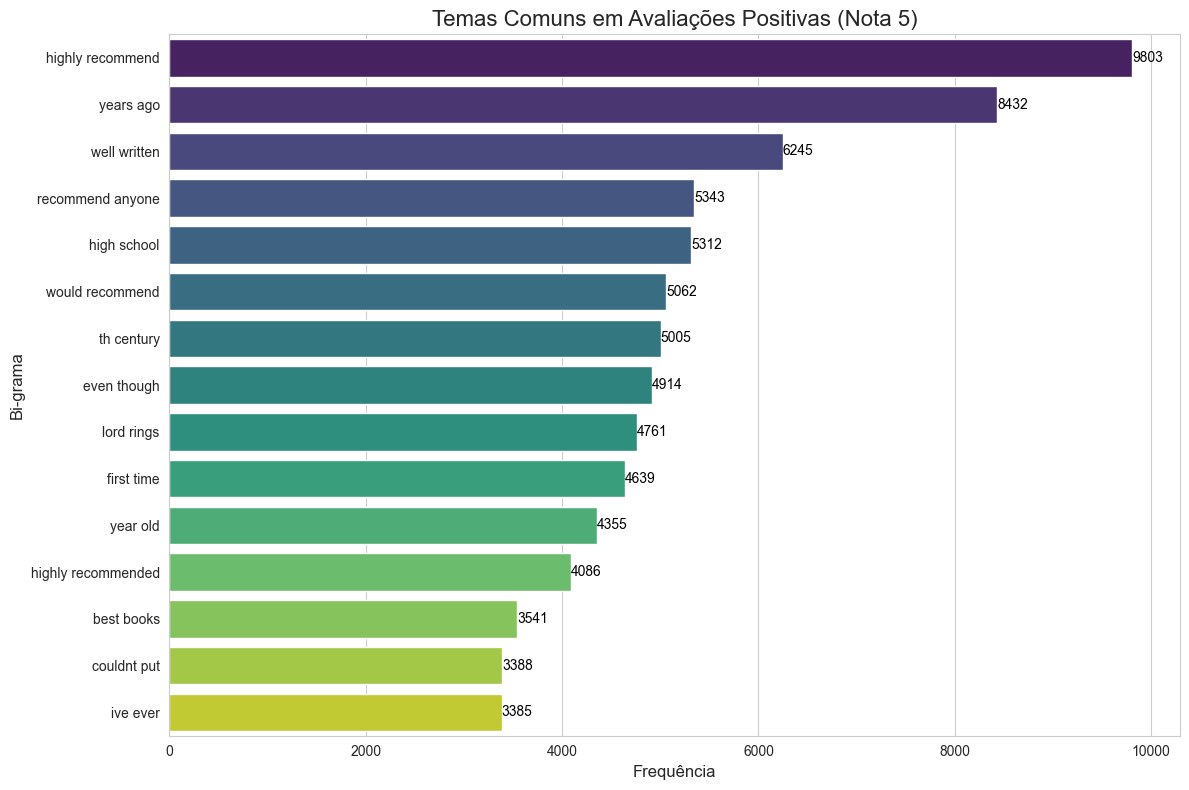

C:\Users\Danilo\AppData\Local\Temp\ipykernel_18568\1024165605.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts, y=ngrams, palette=color)


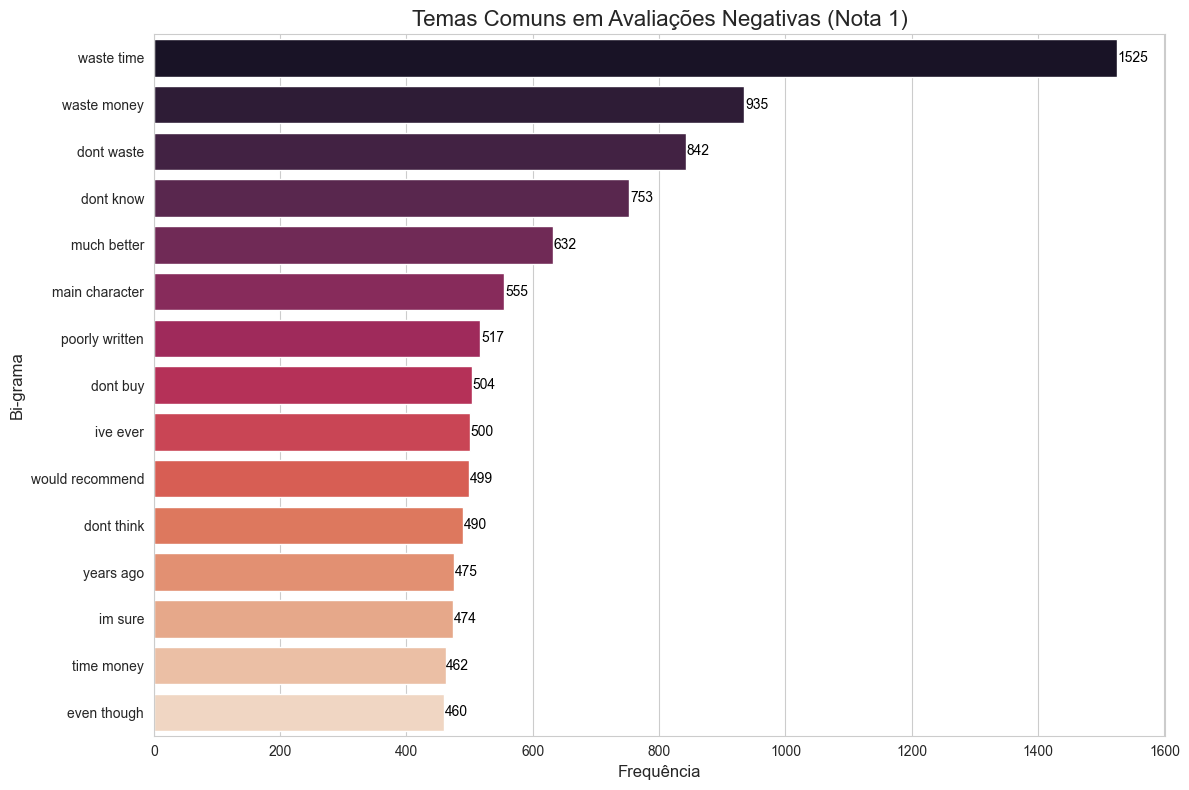

In [25]:
def plot_top_ngrams(ngram_data, title, color):
    ngrams = [' '.join(ngram) for ngram, count in ngram_data]
    counts = [count for ngram, count in ngram_data]
    
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=counts, y=ngrams, palette=color)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Frequência", fontsize=12)
    ax.set_ylabel("Bi-grama", fontsize=12)
    
    # Valores nas barras
    for i, v in enumerate(counts):
        ax.text(v + 1, i, str(v), color='black', va='center', fontsize=10)
        
    plt.tight_layout()
    plt.show()

plot_top_ngrams(top_positive_bigrams, 'Temas Comuns em Avaliações Positivas (Nota 5)', 'viridis')
plot_top_ngrams(top_negative_bigrams, 'Temas Comuns em Avaliações Negativas (Nota 1)', 'rocket')